# -----------------------------
# Imports
# -----------------------------

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)


# Better plots

In [16]:
sns.set(style="whitegrid", palette="viridis")

# -----------------------------
# Load Data
# -----------------------------


In [17]:
train_path = "customer_churn_dataset-training-master.csv"
test_path = "customer_churn_dataset-testing-master.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain head:\n", train_df.head())
print("\nTest head:\n", test_df.head())

Train shape: (440833, 12)
Test shape: (64374, 12)

Train head:
    CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0

# -----------------------------
# Basic Cleaning
# -----------------------------


In [18]:
print("\nMissing values in train:\n", train_df.isna().sum())
print("\nMissing values in test:\n", test_df.isna().sum())


if "CustomerID" in train_df.columns:
    train_df = train_df.drop(columns=["CustomerID"])
if "CustomerID" in test_df.columns:
    test_df = test_df.drop(columns=["CustomerID"])




Missing values in train:
 CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Missing values in test:
 CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


# -----------------------------
# EDA
# -----------------------------

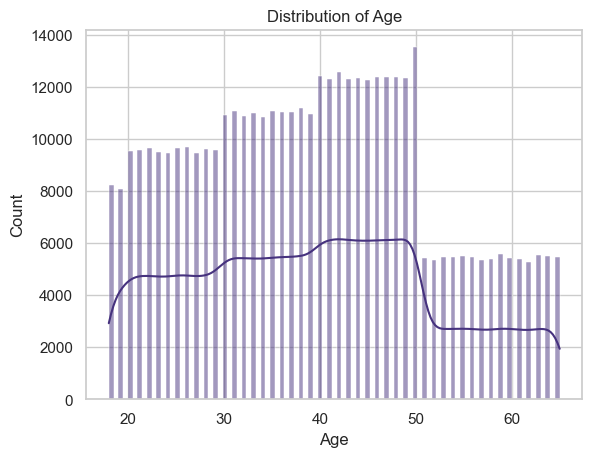

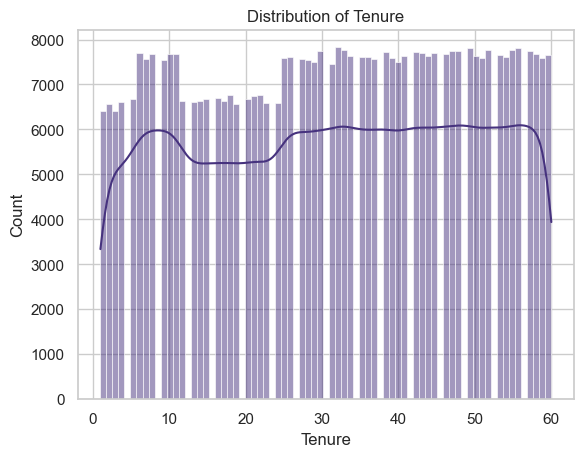

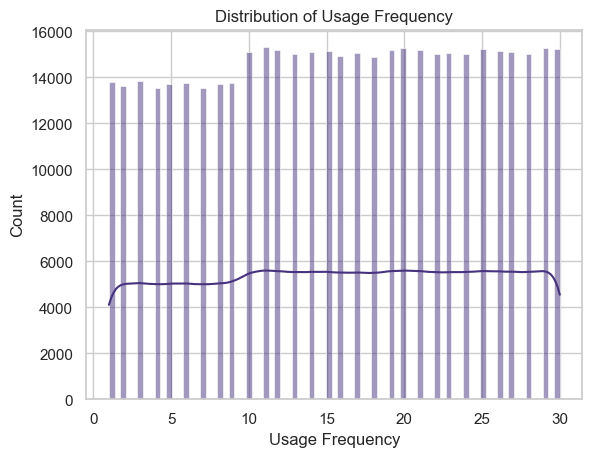

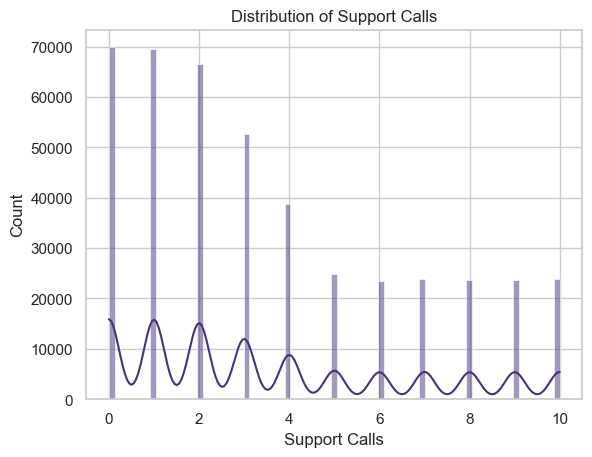

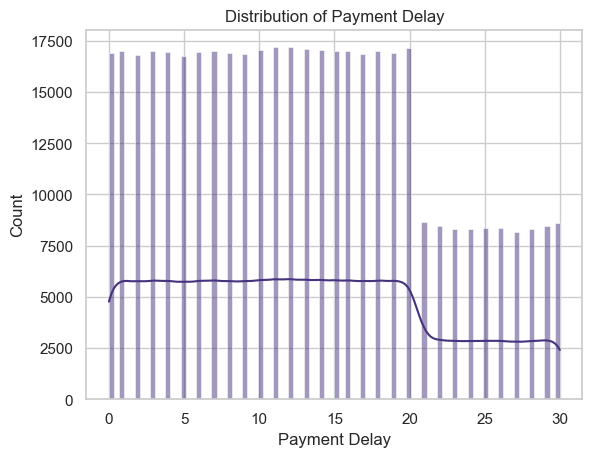

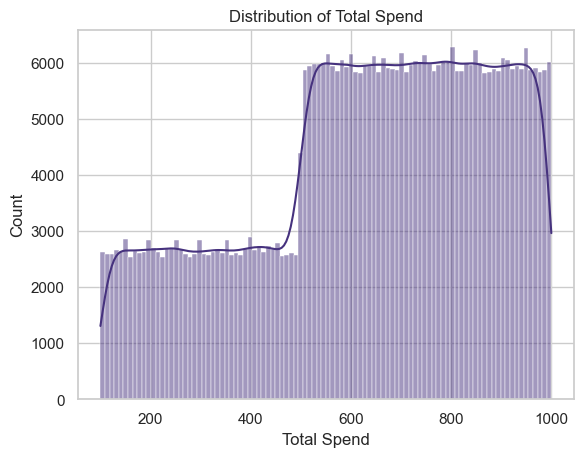

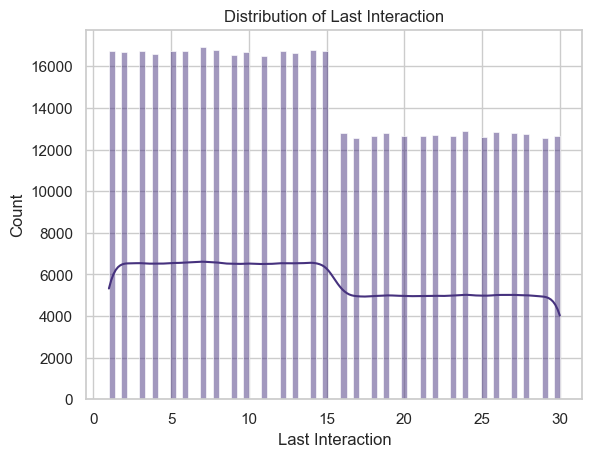

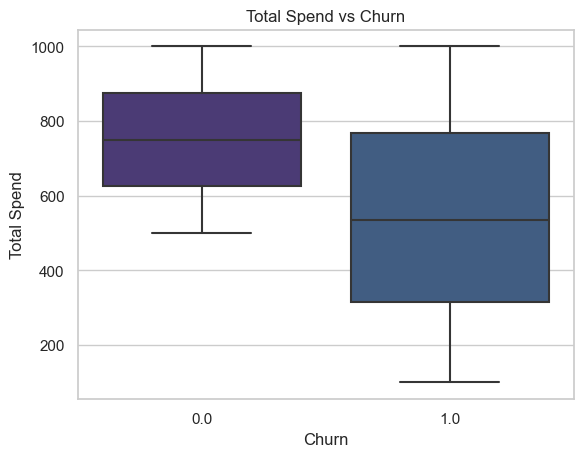

In [19]:
# Numeric columns distribution
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "Churn"]  # exclude target

for col in numeric_cols:
    plt.figure()
    sns.histplot(data=train_df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Churn vs Total Spend
if "Total Spend" in train_df.columns:
    plt.figure()
    sns.boxplot(x="Churn", y="Total Spend", data=train_df)
    plt.title("Total Spend vs Churn")
    plt.show()

# -----------------------------
# Visualization Section
# -----------------------------

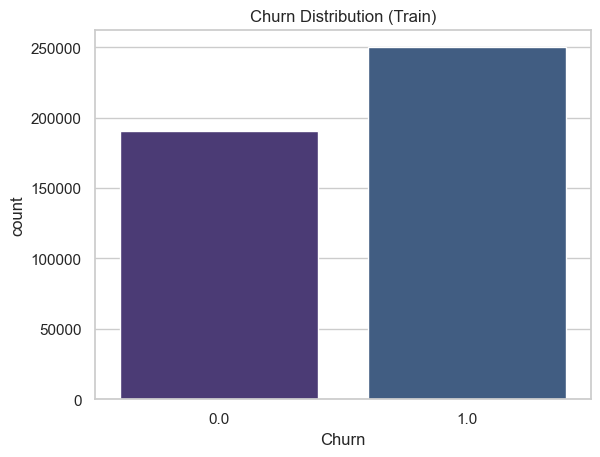

In [20]:
# Churn distribution
plt.figure()
sns.countplot(x="Churn", data=train_df)
plt.title("Churn Distribution (Train)")
plt.show()

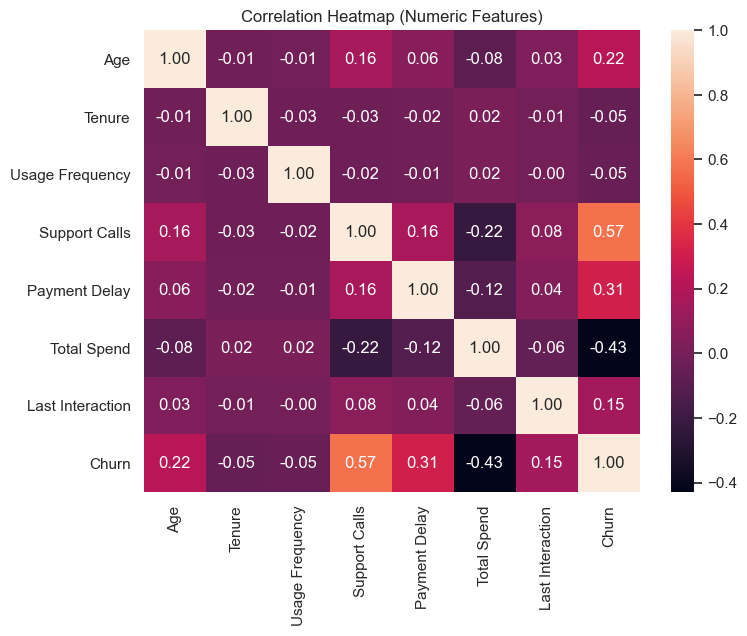

In [21]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(8, 6))
corr = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# ================================
# 5. Prepare data for modeling
# ================================

In [22]:
target_col = "Churn"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

# Drop NaN rows in y
mask_train = ~y_train.isna()
X_train = X_train[mask_train]
y_train = y_train[mask_train]

mask_test = ~y_test.isna()
X_test = X_test[mask_test]
y_test = y_test[mask_test]

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)



Numeric features: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
Categorical features: ['Gender', 'Subscription Type', 'Contract Length']


# ================================
# 6. Preprocessing + Model pipeline
# ================================

In [23]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = LogisticRegression(max_iter=1000)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# ================================
# 7. Train model
# ================================


In [24]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender',
                                                   'Subscription Type',
                                                   'Contract Length'])])),
                ('model', LogisticRegression(max_iter=1000))])

# ================================
# 8. Evaluation
# ================================

In [25]:
# Train metrics
y_pred_train = clf.predict(X_train)
print("\n=== Train Metrics ===")
print("Accuracy (train):", accuracy_score(y_train, y_pred_train))
print("\nClassification report (train):\n", classification_report(y_train, y_pred_train))
print("Confusion matrix (train):\n", confusion_matrix(y_train, y_pred_train))

# Test metrics
y_pred_test = clf.predict(X_test)
print("\n=== Test Metrics ===")
print("Accuracy (test):", accuracy_score(y_test, y_pred_test))
print("\nClassification report (test):\n", classification_report(y_test, y_pred_test))
print("Confusion matrix (test):\n", confusion_matrix(y_test, y_pred_test))




=== Train Metrics ===
Accuracy (train): 0.8953705720092915

Classification report (train):
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.88    190833
         1.0       0.93      0.89      0.91    249999

    accuracy                           0.90    440832
   macro avg       0.89      0.90      0.89    440832
weighted avg       0.90      0.90      0.90    440832

Confusion matrix (train):
 [[172911  17922]
 [ 28202 221797]]

=== Test Metrics ===
Accuracy (test): 0.571302078478889

Classification report (test):
               precision    recall  f1-score   support

           0       0.96      0.19      0.32     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.57     64374
   macro avg       0.74      0.59      0.50     64374
weighted avg       0.75      0.57      0.49     64374

Confusion matrix (test):
 [[ 6571 27310]
 [  287 30206]]
